In [0]:
# connect google drive
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# the folder I use
!ls /content/gdrive/My\ Drive/IFT6135/datasets

loss.npy  loss_plot.png  mnist.pkl.gz  mnist.pkl.npy


In [0]:
path="/content/gdrive/My Drive/IFT6135/datasets/"

In [0]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(666)

In [0]:
class NN(object):
    
    def __init__(self,hidden_dims=(666,666),data_format=[784,10],n_hidden=2,mode='train',datapath=None,model_path=None,initial="Glorot",activations=["sigmoid","sigmoid","softmax"],mini_batch=1,random_state=666):
        """hidden_dims: the size of hidden layers
        data_format:  the feature dims and the label dims(one_hot)
        n_hidden: the number of hidden layer
        mode: mode of the model
        initial: the method of weight initialization
                ["Zero","Normal","Glorot"]
        activations: a list of the type of activation function 
                            ("ReLU","Sigmoid","Softmax")
        mini_batch: the size of mini_batch (default: 1 == SGD)
        
        
        
        Not using sigmoid may cause softmax (exp overflow)
        
        """
        
        
        np.random.seed(random_state)
        
#         self.data=datapath[0]
#         self.label=datapath[1]
        input_dim=data_format[0]
        output_dim=data_format[1]
        self.dims=[input_dim]+list(hidden_dims)+[output_dim]
        self.n_hidden = n_hidden
        self.initialize_weights(initial=initial)
        self.activations=activations
        


    def initialize_weights(self,initial="Glorot"):
    # def initialize_weights(n_hidden,dims,initial):

        # dim=[input_dim,hidden_dims,output_dim]
        # weights not include the bias 
        n_hidden=self.n_hidden
        dims=self.dims
        weights=[]
        biases=[]
        if len(dims)!=n_hidden+2:
            raise ValueError("The length of dims does not match the num of hidden layer") 
        if initial=="Zero":
            for l in range(n_hidden+1):
                weights.append(np.matrix(np.zeros([dims[l],dims[l+1]])))
                biases.append(np.matrix(np.zeros([1,dims[l+1]])))
        elif initial=="Normal":
            for l in range(n_hidden+1):
                weights.append(np.matrix(np.random.normal(0,1,dims[l]*dims[l+1]).reshape([dims[l],dims[l+1]])))
                biases.append(np.matrix(np.zeros([1,dims[l+1]])))
        elif initial=='Glorot':
            for l in range(n_hidden+1):
                d=np.sqrt(6/(dims[l]+dims[l+1]))
                weights.append(np.matrix(np.random.uniform(-d,d,dims[l]*dims[l+1]).reshape([dims[l],dims[l+1]])))
                biases.append(np.matrix(np.zeros([1,dims[l+1]])))
#         elif initial=="He":
#             for l in range(n_hidden+1):
#                 weights.append(np.matrix(np.random.randn(dims[l],dims[l+1]) / np.sqrt(dims[l]/2)))
#                 biases.append(np.matrix(np.zeros([1,dims[l+1]])))

        self.weights=weights
        self.biases=biases





    def forward(self,input_):
        # here input is the data point
        # input: n x m
        
#         input_=input_.reshape(-1,self.dims[0])
        cache=dict()
        
        input_=np.matrix(input_).reshape(-1,self.dims[0])
        mb=input_.shape[0]
        hidden_pre=[]
        hidden_act=[]
        hidden_act.append(input_)
        for i in range(self.n_hidden+1):
#             print(i)
#             print("---")
#             print(input_.shape)
#             print(self.weights[i].shape)
#             print(input_.shape,self.weights[i].shape,self.biases[i].shape)
            output=np.dot(input_,self.weights[i])+np.dot(np.ones([input_.shape[0],1]),self.biases[i])
#             print(output.shape,"pre")
            hidden_pre.append(output)
            output=self.activation(output,act=self.activations[i])
#             print(output.shape,"activation")
            hidden_act.append(output)
            input_=output
#             print("========")
        cache["hidden_pre"]=hidden_pre
        cache["hidden_act"]=hidden_act
        output=output.reshape(-1,self.dims[-1])
        return output,cache


    def activation(self,input,act="ReLU"):
        act=act.lower()
        if act=="relu":
            return self.ReLU(input)
        elif act=="sigmoid":
            return self.sigmoid(input)
        elif act=="softmax":
            return self.softmax(input)
        else:
            raise ValueError("act should be the name of an activation function")

    def softmax(self,X):
        """ with stable setting in case of overflow"""
        e = np.exp(X - np.dot(np.max(X,axis=1),np.ones([1,X.shape[1]])))
        return np.multiply(e,1/np.dot(np.sum(e,axis=1),np.ones([1,X.shape[1]])))


    def sigmoid(self,input):
        index=-input > np.log(np.finfo(np.float).max)   
          
        result=1/(1+np.exp(-input))
        result[index]=0
        
        return result

    def ReLU(self,input):
        input[np.where(input<0)]=0
        return input

    
    
    def loss(self,prediction,label):
        # cross-entropy
        # self
        prediction=np.matrix(prediction)
        label=np.matrix(label)
        prediction[np.where(prediction<=0)]=prediction[np.where(prediction<=0)]+0.0000001
        loss=np.nan_to_num(np.multiply(-label,np.log(prediction)))
        loss=np.sum(loss,axis=1)
        return loss
    

    def derivative(self,input,func,labels=0):
        """if func='crossentropy, labels are require'"""
        func=func.lower()
        func=func.replace(" ","").replace("_","").replace("-","")
        if func=="sigmoid":
            input=np.matrix(input)
            return np.multiply(self.sigmoid(input),(1-self.sigmoid(input)))
        elif func=="relu":
            return (input>0).astype(np.float)
    #     elif func=="softmax":
    #         p=self.softmax(input)
    #         grad_matrix=np.diag(p)-np.dot(p.reshape(-1,1),p.reshape(1,-1))
    #         return np.sum(grad_matrix,axis=0)
    #     elif func=="crossentropy":
    #         labels=labels.reshape(-1)
    #         return input-labels
        else:
            raise ValueError("Please set the function type")


    def backward(self,cache,labels):
        """grad_w,grad_b are with the opposite order"""

        grad_w=[]
        grad_b=[]
        mini_batch=cache["hidden_act"][-1].shape[0] # mini_batch=n
        gradient=cache["hidden_act"][-1]-labels # n x 10
        for i in range(self.n_hidden+1):
            l=self.n_hidden-i
            # activation function
            # pre-activation function
#             print(cache["hidden_act"][l].reshape(mini_batch,-1).transpose())
#             print(gradient.reshape(mini_batch,-1))
#             try:
            grad_w.append((np.dot(cache["hidden_act"][l].transpose(),gradient))/mini_batch)
#             except:
#                 print(cache["hidden_act"][l])
#                 print(gradient)
            b_g=gradient.copy()
            grad_b.append(np.mean(b_g,axis=0))
                
            # gradient update
            if l<=0:
                break
            gradient=np.dot(gradient,self.weights[l].transpose())
            gradient=np.multiply(np.array(gradient),np.array(self.derivative(cache["hidden_pre"][l-1],self.activations[l-1])))

        grads=dict()
        grads["weights"]=[grad_w[self.n_hidden-i] for i in range(self.n_hidden+1)]
        grads["biases"]=[grad_b[self.n_hidden-i] for i in range(self.n_hidden+1)]

        return grads






    def update(self,grads,learning_rate=0.1):
        for i in range(self.n_hidden+1):
            self.weights[i]=self.weights[i]-learning_rate*grads["weights"][i]
            self.biases[i]=self.biases[i]-learning_rate*grads["biases"][i]
        return None




    def train(self,data,labels,epochs=10,learning_rate=0.1,mini_batch=1):
        if labels.shape[1]!=self.dims[-1]:
            raise ValueError("the label format doesn't match the one hot format")
        
        data=np.matrix(data).reshape(-1,self.dims[0])
        labels=np.matrix(labels).reshape(-1,self.dims[-1])
        # set counters zeros
        grads=dict()
        grads["weights"]=[np.zeros(w.shape) for w in self.weights]
        grads["biases"]=[np.zeros(b.shape) for b in self.biases]
        #
        loss_epoch=[]
        batches=data.shape[0]//mini_batch
        acc_epoch=[]
        for epoch in range(epochs):
            for i in range(batches+1):
                if i==batches and data.shape[0]%mini_batch==0:
                    break
                
                X=data[i*mini_batch:np.min([i*mini_batch+mini_batch,data.shape[0]])]
                Y=labels[i*mini_batch:np.min([i*mini_batch+mini_batch,data.shape[0]])]
                prediction,cache=self.forward(X)
#                 print(prediction)
                loss=self.loss(prediction,Y)
                new_grads=self.backward(cache,Y)
                loss_mb=np.mean(loss,axis=0)[0,0]        
                
                print("loss=%f  ---- epoch: %d  mini_batch: %d "%(loss_mb,epoch,i),end="\r")
                self.update(new_grads,learning_rate)
                    # set counter zeros
            
            av_loss,acc=self.test(data,labels)
            loss_epoch.append(av_loss)
            acc_epoch.append(acc)
            print("----------------------")
            print("Average_loss=%f  acc=%f ---- epoch: %d"%(av_loss,acc,epoch),end="\n")          
            print("----------------------")

        return [np.array(loss_epoch),np.array(acc_epoch)]





    def test(self,X,Y):
#         if Y.shape[1]!=self.dims[-1]:
#             raise ValueError("the label format doesn't match the one hot format")
#         for i in range(data.shape[0]):
#             X=data[i]
#             Y=labels[i]
        X=np.matrix(X).reshape(-1,self.dims[0])
        Y=np.matrix(Y).reshape(-1,self.dims[-1])
        prediction,cache=self.forward(X)
        loss=self.loss(prediction,Y)
        av_loss=np.mean(loss,axis=0)[0,0]
        acc=np.mean(np.argmax(prediction,axis=1)==np.argmax(Y,axis=1),axis=0)[0,0]


        return [av_loss,acc]

    
    def valid_gradient(self,X,Y,p=10,eps=1,base=0,base2=0):
        X=np.matrix(X)
        Y=np.matrix(Y)
        prediction,cache=self.forward(X)
        loss=self.loss(prediction,Y)
        grads=self.backward(cache,Y)
        true_grad=grads["weights"][0][base:(base+p),base2]
        
        true_grad=np.array(true_grad).flatten()
        estimate_grad=[]
        loss1=[]
        loss2=[]
        for i in range(p):
            pred_1,_=self.forward_eps(X,eps=eps,index=i+base,index2=base2)
            pred_2,_=self.forward_eps(X,eps=-eps,index=i+base,index2=base2)
            loss_1=self.loss(pred_1,Y)
            loss_2=self.loss(pred_2,Y)
            nabla=(loss_1-loss_2)/(2*eps)
            nabla=nabla[0,0]
            estimate_grad.append(nabla)
            loss1.append(loss_1)
            loss2.append(loss_2)
        estimate_grad=np.array(estimate_grad)
        loss1=np.array(loss1)
        loss2=np.array(loss2)
        return [true_grad,estimate_grad]
        
    def forward_eps(self,input_,eps,index,index2=0):
        # here input is the data point
        # input: m x 1
        cache=dict()
        


        hidden_pre=[]
        hidden_act=[]
        hidden_act.append(input_)
        weights=[i.copy() for i in self.weights]

        weights[0][index,index2]=weights[0][index,index2]+eps

        cache=dict()
        
        input_=np.matrix(input_).reshape(-1,self.dims[0])
        mb=input_.shape[0]

        for i in range(self.n_hidden+1):
#             print(i)
#             print("---")
#             print(input_.shape)
#             print(self.weights[i].shape)
#             print(input_.shape,self.weights[i].shape,self.biases[i].shape)
            output=np.dot(input_,weights[i])+np.dot(np.ones([input_.shape[0],1]),self.biases[i])
#             print(output.shape,"pre")
            hidden_pre.append(output)
            output=self.activation(output,act=self.activations[i])
#             print(output.shape,"activation")
            hidden_act.append(output)
            input_=output
#             print("========")
        cache["hidden_pre"]=hidden_pre
        cache["hidden_act"]=hidden_act
        output=np.matrix(output).reshape(-1,self.dims[-1])
        return output,cache


In [0]:
"""
Load data and preprocessing(one_hot y_labels)
"""
def one_hot_labels(labels,dim=10):
    """put labels to one_hot"""
    labels=labels.reshape(-1)
    index=np.arange(labels.shape[0])
    label=np.zeros([labels.shape[0],dim])
    label[index,labels]=1
    return label


## data preprocessing

data=np.load("/content/gdrive/My Drive/IFT6135/datasets/mnist.pkl.npy",encoding = 'latin1')

train_X=data[0][0]
train_y=data[0][1]
valid_X=data[1][0]
valid_y=data[1][1]
test_X=data[2][0]
test_y=data[2][1]

train_Y=one_hot_labels(train_y)

valid_Y=one_hot_labels(valid_y)

test_Y=one_hot_labels(test_y)


In [0]:
print("\n",train_X.shape,train_Y.shape,"\n",valid_X.shape,valid_Y.shape,"\n",test_X.shape,test_Y.shape)


 (50000, 784) (50000, 10) 
 (10000, 784) (10000, 10) 
 (10000, 784) (10000, 10)


"""demo data for code_debugging"""
demoindex=np.random.randint(0,train_X.shape[0],100)
demo_X=train_X[demoindex]
demo_Y=train_Y[demoindex]


# zero initial 
MLP1=NN(hidden_dims=(666, 666),initial="Zero")

loss_zero,_=MLP1.train(demo_X,demo_Y,epochs=10,mini_batch=100)
print("zero done")

# normal initial 

MLP1=NN(hidden_dims=(666, 666),initial="Normal")

loss_normal,_=MLP1.train(demo_X,demo_Y,epochs=3,mini_batch=100)

print("normal done")

#glorot initial

MLP1=NN(hidden_dims=(666, 666),initial="Glorot")

loss_glorot,_=MLP1.train(demo_X,demo_Y,epochs=3,mini_batch=100)

print("glorot done")

print("loss_zero",loss_zero)
print("loss_normal",loss_normal)
print("loss_glorot",loss_glorot)



Initialization method 

Full training data

Mini_batch=100

activations=["sigmoid","sigmoid","softmax"] 


"""using ReLU may cause the exp() overflow"""

In [0]:


# zero initial 
print("zero initialization")

MLP1=NN(hidden_dims=(666, 666),initial="Zero")

loss_zero,_=MLP1.train(train_X,train_Y,epochs=10,mini_batch=100)
loss_zero=np.array(loss_zero).reshape(1,-1)


# normal initial 

print("normal initialization")


MLP1=NN(hidden_dims=(666, 666),initial="Normal")

loss_normal,_=MLP1.train(train_X,train_Y,epochs=10,mini_batch=100)
loss_normal=np.array(loss_normal).reshape(1,-1)

#glorot initial

print("glorot initialization")


MLP1=NN(hidden_dims=(666, 666),initial="Glorot")
loss_glorot,_=MLP1.train(train_X,train_Y,epochs=10,mini_batch=100)
loss_glorot=np.array(loss_glorot).reshape(1,-1)



loss=np.concatenate([loss_zero,loss_normal,loss_glorot],axis=0)


loss_zero=loss_zero.reshape(-1)
loss_normal=loss_normal.reshape(-1)
loss_glorot=loss_glorot.reshape(-1)

print("loss_zero",loss_zero)
print("loss_normal",loss_normal)
print("loss_glorot",loss_glorot)


np.save("/content/gdrive/My Drive/IFT6135/datasets/loss.npy",loss)




zero initialization
----------------------
Average_loss=2.308792  acc=0.099360 ---- epoch: 0
----------------------
----------------------
Average_loss=2.304842  acc=0.102020 ---- epoch: 1
----------------------
----------------------
Average_loss=2.303269  acc=0.102020 ---- epoch: 2
----------------------
----------------------
Average_loss=2.300464  acc=0.176960 ---- epoch: 3
----------------------
----------------------
Average_loss=2.290060  acc=0.122000 ---- epoch: 4
----------------------
----------------------
Average_loss=2.237993  acc=0.180140 ---- epoch: 5
----------------------
----------------------
Average_loss=2.077122  acc=0.257860 ---- epoch: 6
----------------------
----------------------
Average_loss=1.953895  acc=0.291320 ---- epoch: 7
----------------------
----------------------
Average_loss=1.880743  acc=0.307660 ---- epoch: 8
----------------------
----------------------
Average_loss=1.824576  acc=0.319160 ---- epoch: 9
----------------------
normal initializatio

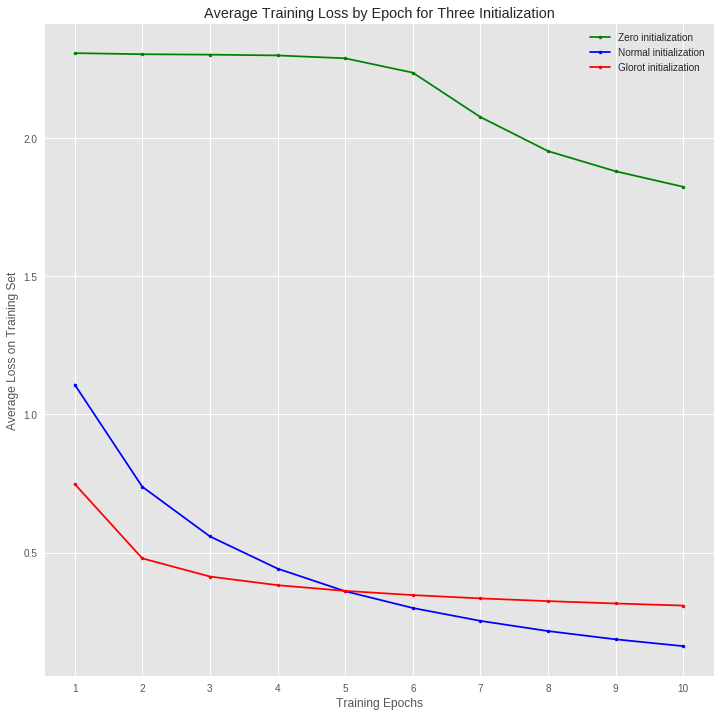

In [0]:
epochs=np.arange(10)+1



plt.style.use('ggplot')
plt.figure(figsize=[12,12])
plt.plot(epochs,loss_zero,"g.-",label="Zero initialization")
plt.plot(epochs,loss_normal,"b.-",label="Normal initialization")
plt.plot(epochs,loss_glorot,"r.-",label="Glorot initialization")
plt.xlabel("Training Epochs",fontsize=15)
plt.ylabel("Average Loss on Training Set",fontsize=15)
plt.xticks(epochs)
plt.legend(loc="upper right",fontsize=15)
plt.title("Average Training Loss by Epoch for Three Initialization",fontsize=20)
plt.savefig(path+"loss_plot.png")
plt.show()


# Problem 1 - Initialization
 
The strcuture of the NN:
- Model Architecture:
  - Hidden Layer size: [666, 666]
  - Total parameters: 973702 $\in$ [0.5M, 1.0M]
- Nonlinearity:
  - [Sigmoid, Sigmoid, Softmax]
- Other Hyperparameters:
  - Mini batach size: 100 
  - learning rate:  0.1
  
  
  
**Comments:**
  
  
      
      
      

# Problem 1 - Hyperparameter search

### 1. Validation Acc: 0.932400 

  The strcuture of the NN:
  - Model Architecture:
     - Hidden Layer size: [666, 666]
      - Total parameters: 973702 $\in$ [0.5M, 1.0M]
  - Nonlinearity:
     - [Sigmoid, Sigmoid, Softmax]
  - Other Hyperparameters:
     - Mini batach size: 100 
     - learning rate:  0.1
    
    
    Result
     - Loss
        - Training: 0.307930 
        - Validation: 0.237030 
      - Accuracy
         - Training: 0.909060
         - Validation: 0.932400
       
       
### 2. Validation Acc: 0.978600

  The strcuture of the NN:
  - Model Architecture:
     - Hidden Layer size: [666, 666]
      - Total parameters: 973702 $\in$ [0.5M, 1.0M]
  - Nonlinearity:
     - [ReLU, ReLU, Softmax]
  - Other Hyperparameters:
     - Mini batach size: 100 
     - learning rate:  0.1
    
    
    Result
      - Loss
        - Training: 0.031310
        - Validation: 0.076124 
     - Accuracy
       - Training: 0.991800
       - Validation: 0.978600
 

In [0]:
valid_loss,valid_acc=MLP1.test(valid_X,valid_Y)
print("The loss of Validation set: %f \nThe Accuaracy of Validation set: %f"%(valid_loss,valid_acc))

The loss of Validation set: 0.237030 
The Accuaracy of Validation set: 0.932400


In [0]:

MLP2=NN(hidden_dims=(666, 666),initial="Glorot",activations=["ReLU","ReLU","softmax"])
loss_,acc=MLP2.train(train_X,train_Y,epochs=10,mini_batch=100)
loss_=np.array(loss_).reshape(1,-1)
print("Training Loss",loss_)
print("Training Acc",acc)

----------------------
Average_loss=0.225571  acc=0.934900 ---- epoch: 0
----------------------
----------------------
Average_loss=0.147600  acc=0.956860 ---- epoch: 1
----------------------
----------------------
Average_loss=0.109827  acc=0.967980 ---- epoch: 2
----------------------
----------------------
Average_loss=0.086644  acc=0.975340 ---- epoch: 3
----------------------
----------------------
Average_loss=0.070970  acc=0.980080 ---- epoch: 4
----------------------
----------------------
Average_loss=0.059206  acc=0.983460 ---- epoch: 5
----------------------
----------------------
Average_loss=0.049881  acc=0.986140 ---- epoch: 6
----------------------
----------------------
Average_loss=0.042339  acc=0.988560 ---- epoch: 7
----------------------
----------------------
Average_loss=0.036194  acc=0.990520 ---- epoch: 8
----------------------
----------------------
Average_loss=0.031310  acc=0.991800 ---- epoch: 9
----------------------
Training Loss [[0.22557148 0.14760026 0.

In [0]:
valid_loss,valid_acc=MLP2.test(valid_X,valid_Y)
print("The loss of Validation set: %f \nThe Accuaracy of Validation set: %f"%(valid_loss,valid_acc))

The loss of Validation set: 0.076124 
The Accuaracy of Validation set: 0.978600


# Problem 1 --- Validate Gradients using Finite Difference

In [0]:
p=10
i=[1,3,5]
k=[1,5]
N=[(k_*100+10)**i_ for i_ in i for k_ in k]
N=[1]+N
X=np.matrix(train_X)[-1]
Y=np.matrix(train_Y)[-1]


In [0]:
result=[]
for N_ in N:
  eps=1/N_
  result.append(MLP2.valid_gradient(X,Y,p=10,eps=eps))
  
 

In [0]:
result_adjust=[]
for N_ in N:
  eps=1/N_
  result_adjust.append(MLP2.valid_gradient(X,Y,p=10,eps=eps,base=204,base2=11))
  
 

When the weights are selected as the requirement, due to the sample, all gradients are zero.
Therefore, we adjust the selection of weights to validate.

In [0]:
result

[[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]]

In [0]:
result_adjust

[[array([2.38714228e-05, 3.50726289e-04, 4.64574613e-04, 4.13159241e-04,
         2.20351595e-04, 1.02830744e-04, 4.64574613e-04, 3.21346076e-04,
         0.00000000e+00, 1.13848324e-04]),
  array([2.38687242e-05, 2.65374241e-04, 3.67629359e-04, 3.19831318e-04,
         1.67657961e-04, 9.76431370e-05, 3.67629359e-04, 2.40665902e-04,
         0.00000000e+00, 1.03390981e-04])],
 [array([2.38714228e-05, 3.50726289e-04, 4.64574613e-04, 4.13159241e-04,
         2.20351595e-04, 1.02830744e-04, 4.64574613e-04, 3.21346076e-04,
         0.00000000e+00, 1.13848324e-04]),
  array([2.38714229e-05, 3.50726551e-04, 4.64575223e-04, 4.13159670e-04,
         2.20351660e-04, 1.02830751e-04, 4.64575223e-04, 3.21346278e-04,
         0.00000000e+00, 1.13848333e-04])],
 [array([2.38714228e-05, 3.50726289e-04, 4.64574613e-04, 4.13159241e-04,
         2.20351595e-04, 1.02830744e-04, 4.64574613e-04, 3.21346076e-04,
         0.00000000e+00, 1.13848324e-04]),
  array([2.38714228e-05, 3.50726301e-04, 4.64574642e-

In [0]:
max_diff=[]
for i in result_adjust:
  diff=np.abs(i[0]-i[1])
  diff=np.max(diff)
  max_diff.append(diff)
  
  


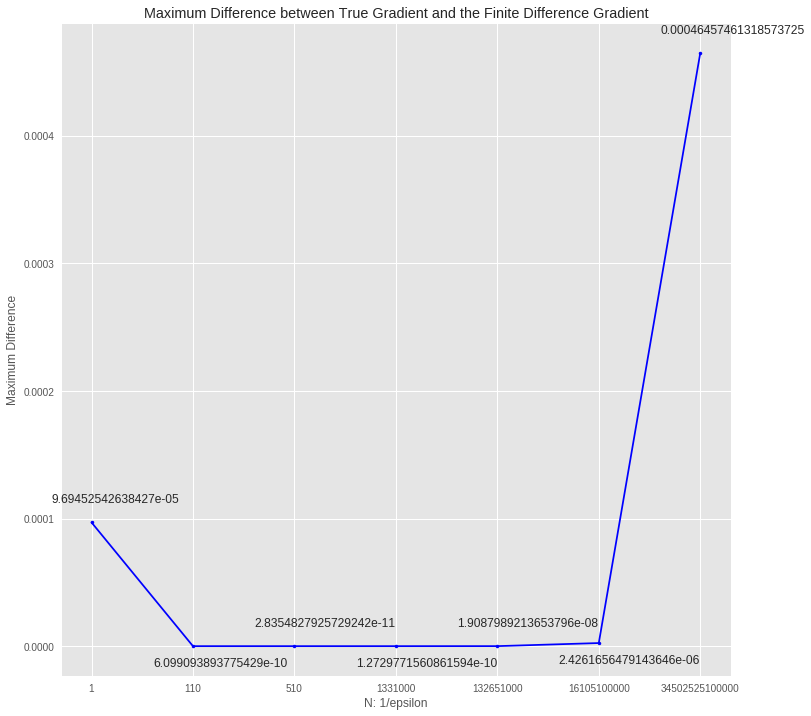

In [0]:
x_axis=np.arange(len(max_diff))



plt.style.use('ggplot')
plt.figure(figsize=[12,12])
plt.plot(x_axis,max_diff,"b.-")

plt.xlabel(r"$N: 1/\epsilon$",fontsize=15)
plt.ylabel("Maximum Difference",fontsize=15)
plt.xticks(x_axis,N)
plt.title("Maximum Difference between True Gradient and the Finite Difference Gradient",fontsize=20)
count=0
for xy in zip(x_axis,max_diff):
    plt.annotate(max_diff[count], xy=xy, xycoords='data', xytext=(-40, (-1)**count*20),
             textcoords='offset points', fontsize=12)
    count+=1

plt.savefig(path+"Finite_diff.png")
plt.show()